# Data Preprocessing
- The Missing values are for sensor and it makes sense to fill them with zero,since filling the missing values with an acutal value might cause misleading.
- There are 6000 rows and 10 columns for each of the csv files within train and test folders. This amount of data needs reduction. I have performed PCA on the transposed version of the csv files. This process will change the 6000 x 10 csv file to 10 x 10 csv file.
- The PCA model is fitted on the first csv file of the train directory to keep the dimension reduction consistent on all the logs.

In [2]:
import numpy as np
import pandas as pd 

# Paths to the training and testing datasets
train_path = '/kaggle/input/predict-volcanic-eruptions-ingv-oe/train/'
test_path = '/kaggle/input/predict-volcanic-eruptions-ingv-oe/test/'

# Training data
train = pd.read_csv('/kaggle/input/predict-volcanic-eruptions-ingv-oe/train.csv')
sample_submission = pd.read_csv('/kaggle/input/predict-volcanic-eruptions-ingv-oe/sample_submission.csv')

# Getting the ids
train_ids = train['segment_id']
test_ids = sample_submission['segment_id']

# Value to be predicted
y = train['time_to_eruption']

# Measures of Central Tendency for raw data
X = np.load('/kaggle/input/volcano-pca/train.npy')
X_test = np.load('/kaggle/input/volcano-pca/test.npy')

# Measures of Central Tendency for rolling data
X_rolling = np.load('/kaggle/input/volcano-pca/rolling_train.npy')
X_rolling_test = np.load('/kaggle/input/volcano-pca/rolling_test.npy')

In [4]:
# Importing the needed utilities for NN
import tensorflow as tf
from tensorflow.keras import Model, Input, models
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.layers import BatchNormalization, Dropout, Flatten, Dense, InputLayer, Concatenate, Add, SeparableConv2D, Layer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.initializers import TruncatedNormal

# Data Preprocessing utilities
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold

# Importing the plotting utilities
import pylab as plot
from matplotlib import pyplot as plt

# Setting the parameters for plotting
# params = {'legend.fontsize': 20,
#           'legend.handlelength': 5,
#           'xtick.labelsize' : 30,
#           'ytick.labelsize' : 30,
#          'axes.titlesize' : 50}

# plot.rcParams.update(params)

In [5]:
WInit = TruncatedNormal(0, 1, 111)

In [83]:
def decoder1(inp, unit=16, code=1):
    o = SeparableConv2D(unit, (3, 3), kernel_initializer=WInit, name=f'{code}1')(inp)
    o = SeparableConv2D(unit, (1, 3), kernel_initializer=WInit, name=f'{code}2')(o)
    o = SeparableConv2D(unit, (3, 1), kernel_initializer=WInit, name=f'{code}3')(o)
    o = BatchNormalization()(o)
    
    f = Flatten()(o)
    
    c = Dense(512, kernel_initializer=WInit)(f)
    c = Dense(128, kernel_initializer=WInit)(c)
    c = Dense(64, kernel_initializer=WInit)(c)
    
    p = Dense(1, kernel_initializer=WInit, name='1')(c)
    
    return p

def decoder2(inp, unit=16, code=2):
    o = SeparableConv2D(unit, (3, 3), kernel_initializer=WInit, name=f'{code}1')(inp)
    o = SeparableConv2D(unit, (5, 3), kernel_initializer=WInit, name=f'{code}2')(o)
    o = SeparableConv2D(unit, (3, 5), kernel_initializer=WInit, name=f'{code}3')(o)
    o = BatchNormalization()(o)
    
    f = Flatten()(o)
    
    c = Dense(512, kernel_initializer=WInit)(f)
    c = Dense(128, kernel_initializer=WInit)(c)
    c = Dense(64, kernel_initializer=WInit)(c)
    
    p = Dense(1, kernel_initializer=WInit, name='2')(c)
    
    return p

def decoder3(inp, unit=16, code=3):
    o = SeparableConv2D(unit, (1, 10), kernel_initializer=WInit, name=f'{code}1')(inp)
    o = SeparableConv2D(unit, (2, 2), kernel_initializer=WInit, name=f'{code}2')(o)
    o = SeparableConv2D(unit, (3, 3), kernel_initializer=WInit, name=f'{code}3')(o)
    o = BatchNormalization()(o)
    
    f = Flatten()(o)
    
    c = Dense(512, kernel_initializer=WInit)(f)
    c = Dense(128, kernel_initializer=WInit)(c)
    c = Dense(64, kernel_initializer=WInit)(c)
    
    p = Dense(1, kernel_initializer=WInit, name='3')(c)
    
    return p

def decoder4(inp, unit=16, code=4):
    o = SeparableConv2D(unit, (7, 7), kernel_initializer=WInit, name=f'{code}1')(inp)
    o = SeparableConv2D(unit, (5, 5), kernel_initializer=WInit, name=f'{code}2')(o)
    o = SeparableConv2D(unit, (3, 3), kernel_initializer=WInit, name=f'{code}3')(o)
    o = BatchNormalization()(o)
    
    f = Flatten()(o)
    
    c = Dense(512, kernel_initializer=WInit)(f)
    c = Dense(128, kernel_initializer=WInit)(c)
    c = Dense(64, kernel_initializer=WInit)(c)
    
    p = Dense(1, kernel_initializer=WInit, name='3')(c)
    
    return p

In [84]:
# Input
In = Input(shape=(10,16,1))

out1 = decoder1(In)
out2 = decoder2(In)
out3 = decoder3(In)

out = Concatenate(name='comb')([out1, out2, out3])
out = Dense(1, kernel_initializer=WInit, name='c')(out)

model = Model(inputs=[In], outputs=[out, out1, out2, out3])

In [85]:
model.count_params() / 1e6

1.176499

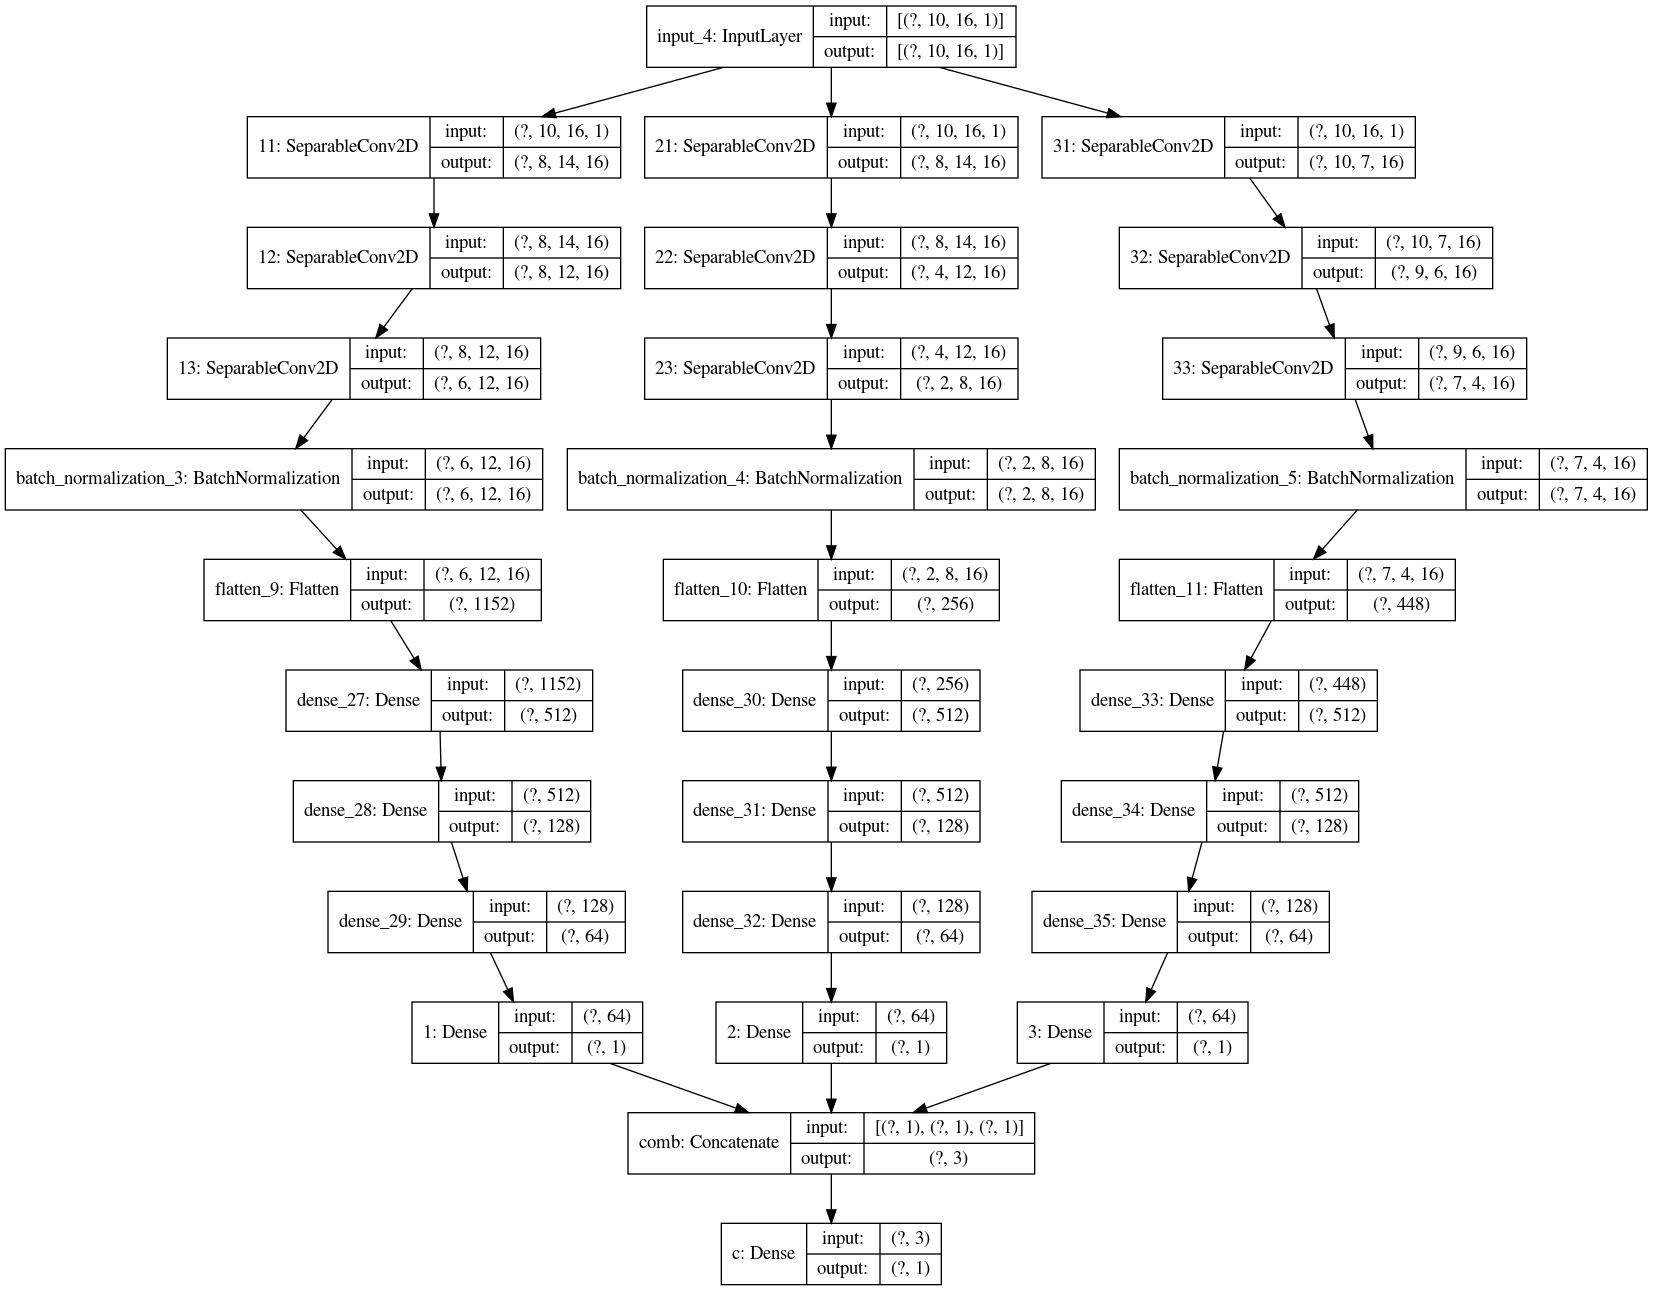

In [28]:
plot_model(model, show_layer_names=1, show_shapes=1)

In [80]:
WInit((64,1))[:10]

<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
array([[ 0.36231187],
       [ 0.18865407],
       [-0.31605548],
       [-0.99769825],
       [ 0.8516323 ],
       [ 0.5310765 ],
       [ 0.6461512 ],
       [ 0.37571263],
       [ 0.09399657],
       [-1.3879474 ]], dtype=float32)>

In [78]:
model.get_layer(name="1").get_weights()[0][:10]

array([[ 0.4288704 ],
       [ 0.41750592],
       [-0.5681576 ],
       [-1.2357936 ],
       [ 1.1013372 ],
       [ 0.7799373 ],
       [ 0.8451439 ],
       [ 0.5826395 ],
       [ 0.33655828],
       [-1.6329556 ]], dtype=float32)

In [30]:
model.compile(optimizer=Adam(0.0015), loss='mae',)

hist = model.fit(X, y, epochs= 100, batch_size=32,
                 callbacks=[ReduceLROnPlateau(monitor='c_loss', factor=0.9, patience=10, verbose=1, min_lr=0)],
                  verbose=True,
                  validation_split=0.33,
                  shuffle=True) 

Epoch 1/100
93/93 [==============================] - 1s 13ms/step - loss: 41158508.0000 - c_loss: 10254638.0000 - 1_loss: 10341543.0000 - 2_loss: 10232032.0000 - 3_loss: 10330300.0000 - val_loss: 40964696.0000 - val_c_loss: 10230005.0000 - val_1_loss: 10295297.0000 - val_2_loss: 10215747.0000 - val_3_loss: 10223648.0000
Epoch 2/100
93/93 [==============================] - 1s 9ms/step - loss: 41140188.0000 - c_loss: 10252079.0000 - 1_loss: 10313591.0000 - 2_loss: 10251669.0000 - 3_loss: 10322842.0000 - val_loss: 42002244.0000 - val_c_loss: 10541479.0000 - val_1_loss: 10398874.0000 - val_2_loss: 10787645.0000 - val_3_loss: 10274241.0000
Epoch 3/100
93/93 [==============================] - 1s 9ms/step - loss: 41112824.0000 - c_loss: 10238632.0000 - 1_loss: 10328850.0000 - 2_loss: 10216373.0000 - 3_loss: 10328973.0000 - val_loss: 41025420.0000 - val_c_loss: 10249691.0000 - val_1_loss: 10297660.0000 - val_2_loss: 10238017.0000 - val_3_loss: 10240053.0000
Epoch 4/100
93/93 [=================

Epoch 26/100
93/93 [==============================] - 1s 9ms/step - loss: 40679136.0000 - c_loss: 10144204.0000 - 1_loss: 10209256.0000 - 2_loss: 10135599.0000 - 3_loss: 10190077.0000 - val_loss: 41336604.0000 - val_c_loss: 10335170.0000 - val_1_loss: 10358768.0000 - val_2_loss: 10366844.0000 - val_3_loss: 10275820.0000
Epoch 27/100
93/93 [==============================] - 1s 10ms/step - loss: 40935960.0000 - c_loss: 10206119.0000 - 1_loss: 10285144.0000 - 2_loss: 10199586.0000 - 3_loss: 10245123.0000 - val_loss: 40760212.0000 - val_c_loss: 10184053.0000 - val_1_loss: 10197840.0000 - val_2_loss: 10253112.0000 - val_3_loss: 10125211.0000
Epoch 28/100
93/93 [==============================] - 1s 12ms/step - loss: 40819268.0000 - c_loss: 10165812.0000 - 1_loss: 10262404.0000 - 2_loss: 10138806.0000 - 3_loss: 10252253.0000 - val_loss: 40836268.0000 - val_c_loss: 10196622.0000 - val_1_loss: 10208727.0000 - val_2_loss: 10268256.0000 - val_3_loss: 10162662.0000
Epoch 29/100
93/93 [============

Epoch 51/100
93/93 [==============================] - 1s 11ms/step - loss: 40650232.0000 - c_loss: 10139958.0000 - 1_loss: 10205330.0000 - 2_loss: 10146572.0000 - 3_loss: 10158368.0000 - val_loss: 41042212.0000 - val_c_loss: 10256252.0000 - val_1_loss: 10309479.0000 - val_2_loss: 10310146.0000 - val_3_loss: 10166327.0000
Epoch 52/100
93/93 [==============================] - 2s 17ms/step - loss: 40763072.0000 - c_loss: 10170023.0000 - 1_loss: 10231890.0000 - 2_loss: 10184522.0000 - 3_loss: 10176635.0000 - val_loss: 40657656.0000 - val_c_loss: 10157852.0000 - val_1_loss: 10205845.0000 - val_2_loss: 10184934.0000 - val_3_loss: 10109025.0000
Epoch 53/100
93/93 [==============================] - 1s 10ms/step - loss: 40802408.0000 - c_loss: 10166430.0000 - 1_loss: 10229560.0000 - 2_loss: 10191214.0000 - 3_loss: 10215202.0000 - val_loss: 40917444.0000 - val_c_loss: 10226687.0000 - val_1_loss: 10306305.0000 - val_2_loss: 10237446.0000 - val_3_loss: 10147001.0000
Epoch 54/100
93/93 [===========

Epoch 76/100
93/93 [==============================] - 1s 9ms/step - loss: 40450368.0000 - c_loss: 10070968.0000 - 1_loss: 10198578.0000 - 2_loss: 10043483.0000 - 3_loss: 10137337.0000 - val_loss: 41148384.0000 - val_c_loss: 10282946.0000 - val_1_loss: 10369654.0000 - val_2_loss: 10309445.0000 - val_3_loss: 10186335.0000
Epoch 77/100
93/93 [==============================] - 1s 9ms/step - loss: 40440440.0000 - c_loss: 10090705.0000 - 1_loss: 10170532.0000 - 2_loss: 10095615.0000 - 3_loss: 10083585.0000 - val_loss: 41211556.0000 - val_c_loss: 10306939.0000 - val_1_loss: 10330897.0000 - val_2_loss: 10328000.0000 - val_3_loss: 10245718.0000
Epoch 78/100
93/93 [==============================] - 1s 10ms/step - loss: 40343012.0000 - c_loss: 10070327.0000 - 1_loss: 10133013.0000 - 2_loss: 10065422.0000 - 3_loss: 10074256.0000 - val_loss: 40891856.0000 - val_c_loss: 10233877.0000 - val_1_loss: 10274849.0000 - val_2_loss: 10256072.0000 - val_3_loss: 10127055.0000
Epoch 79/100
93/93 [=============

Epoch 100/100
93/93 [==============================] - 1s 9ms/step - loss: 40343436.0000 - c_loss: 10052053.0000 - 1_loss: 10149383.0000 - 2_loss: 10050658.0000 - 3_loss: 10091345.0000 - val_loss: 41219788.0000 - val_c_loss: 10289494.0000 - val_1_loss: 10359277.0000 - val_2_loss: 10328261.0000 - val_3_loss: 10242748.0000


In [31]:
v= pd.DataFrame(hist.history)
v['loss'] /= 4
v['val_loss'] /= 4

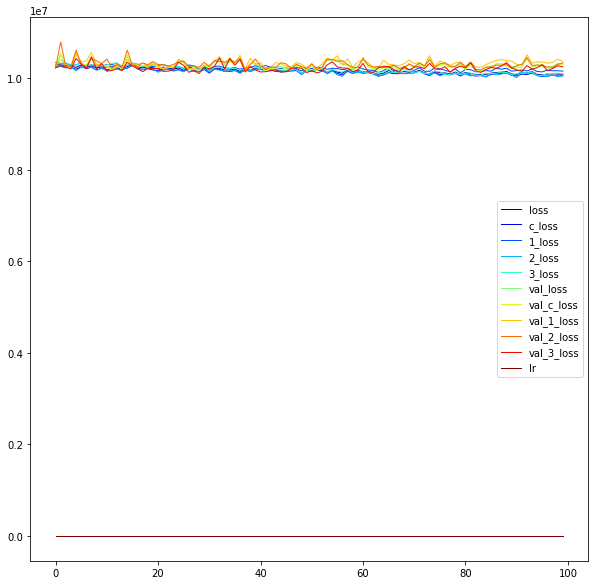

In [32]:
v.plot(figsize=(10,10),
                       rot=0, 
                       lw=1, 
                       colormap='jet',
                      )
plt.legend(fontsize=10)
plt.show()

In [47]:
p1 = np.reshape(model.predict(X_test)[0], 4520)
p2 = np.reshape(model.predict(X_test)[0], 4520)
p3 = np.reshape(model.predict(X_test)[0], 4520)
p4 = np.reshape(model.predict(X_test)[0], 4520)

In [50]:
pd.Series(p1)

0       24998830.0
1       26646724.0
2       26055534.0
3       30059006.0
4       21381996.0
           ...    
4515    17267220.0
4516    22630324.0
4517    27469846.0
4518    24740200.0
4519    26103050.0
Length: 4520, dtype: float32

In [57]:
(p1 - p2).sum()

0.0

In [55]:
pd.concat([pd.Series(p1),pd.Series(p2),pd.Series(p3),pd.Series(p4)], axis=1)

,0,1,2,3
0,24998830.0,24998830.0,24998830.0,24998830.0
1,26646724.0,26646724.0,26646724.0,26646724.0
2,26055534.0,26055534.0,26055534.0,26055534.0
3,30059006.0,30059006.0,30059006.0,30059006.0
4,21381996.0,21381996.0,21381996.0,21381996.0
...,...,...,...,...
4515,17267220.0,17267220.0,17267220.0,17267220.0
4516,22630324.0,22630324.0,22630324.0,22630324.0
4517,27469846.0,27469846.0,27469846.0,27469846.0
4518,24740200.0,24740200.0,24740200.0,24740200.0


In [97]:
sample_submission.to_csv('Submission', index=False)

In [100]:
pd.DataFrame(X_rolling[0])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,-2.051017,73.864767,0.042132,533.480000,278.872929,93.720306,0.758839,672.429893,-0.039025,0.409666,-0.137840,3.600014,1160.782120,339.984852,0.675964,2530.0
1,4.484242,31.105837,0.349309,749.320000,639.805111,226.251348,1.464468,1540.247309,-0.000563,0.260151,0.006572,2.953706,3395.820453,1332.646455,1.745468,9860.0
2,3.064216,62.863276,-0.032905,455.233333,273.500117,77.821094,1.027161,629.952787,0.024439,0.323952,-0.153320,2.778035,1318.405810,355.758289,0.868109,2866.0
3,2.073249,55.248719,-0.033467,459.943333,375.919378,59.790868,0.820511,597.099285,0.024409,0.278691,-0.196769,3.089971,1925.714988,313.347975,0.579078,2960.0
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.0
5,-9.635820,181.516118,0.114508,1260.961055,631.757167,234.839660,0.684545,1245.188937,-0.051769,0.404505,0.054930,3.618696,2617.543808,703.485396,0.488627,4994.0
6,8.212379,118.200792,0.064503,1072.546667,487.159810,145.070628,0.759572,998.793702,0.032788,0.330709,0.072773,3.544767,2308.466676,648.420154,0.942997,4869.0
7,2.275686,158.729713,0.417880,1781.240000,579.772863,165.848399,0.783158,1056.216495,-0.003079,0.303328,-0.254950,2.809450,2720.525008,611.970920,0.584613,4943.0
8,1.541362,47.759640,-0.160323,813.586667,362.893703,69.631461,1.124021,520.377837,-0.006494,0.221197,-0.364209,2.766877,1970.546624,382.542748,0.650790,3768.0
9,2.993027,129.640231,-0.122649,1223.543333,564.460497,147.225795,0.794522,1163.703479,-0.000297,0.335405,0.086086,3.115131,2571.120398,597.846909,0.916266,5517.0


In [86]:
model.compile(optimizer=Adam(0.0015), loss='mae',)

hist = model.fit(X_rolling, y, epochs= 300, batch_size=32,
                 callbacks=[ReduceLROnPlateau(monitor='c_loss', factor=0.9, patience=10, verbose=1, min_lr=0)],
                  verbose=True,
                  validation_split=0.33,
                  shuffle=True) 

Epoch 1/300
93/93 [==============================] - 2s 21ms/step - loss: nan - c_loss: nan - 1_loss: nan - 2_loss: nan - 3_loss: nan - val_loss: nan - val_c_loss: nan - val_1_loss: nan - val_2_loss: nan - val_3_loss: nan
Epoch 2/300
93/93 [==============================] - 1s 11ms/step - loss: nan - c_loss: nan - 1_loss: nan - 2_loss: nan - 3_loss: nan - val_loss: nan - val_c_loss: nan - val_1_loss: nan - val_2_loss: nan - val_3_loss: nan
Epoch 3/300
93/93 [==============================] - 1s 10ms/step - loss: nan - c_loss: nan - 1_loss: nan - 2_loss: nan - 3_loss: nan - val_loss: nan - val_c_loss: nan - val_1_loss: nan - val_2_loss: nan - val_3_loss: nan
Epoch 4/300
93/93 [==============================] - 1s 10ms/step - loss: nan - c_loss: nan - 1_loss: nan - 2_loss: nan - 3_loss: nan - val_loss: nan - val_c_loss: nan - val_1_loss: nan - val_2_loss: nan - val_3_loss: nan
Epoch 5/300
93/93 [==============================] - 1s 11ms/step - loss: nan - c_loss: nan - 1_loss: nan - 2_lo

KeyboardInterrupt: 